In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os 
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [7]:
import functions as fn

# 1. Threshold plots

## 1.1. EM (Jaccard)

In [96]:
def extract_metrics_from_excel(file_path, metric_name):
    # Load the Excel file
    excel_data = pd.ExcelFile(file_path)
    
    # Function to extract metrics
    def extract_metric(model_data, metric_name):
        metric_row = model_data[model_data['Metric'] == metric_name]
        return {
            'Noise_0_Mean': metric_row['Noise_0_Mean'].values[0],
            'Noise_20_Mean': metric_row['Noise_20_Mean'].values[0],
            'Noise_40_Mean': metric_row['Noise_40_Mean'].values[0],
            'Noise_60_Mean': metric_row['Noise_60_Mean'].values[0],
            'Noise_80_Mean': metric_row['Noise_80_Mean'].values[0],
            'Noise_100_Mean': metric_row['Noise_100_Mean'].values[0],
            'Noise_0_Std': metric_row['Noise_0_Std'].values[0],
            'Noise_20_Std': metric_row['Noise_20_Std'].values[0],
            'Noise_40_Std': metric_row['Noise_40_Std'].values[0],
            'Noise_60_Std': metric_row['Noise_60_Std'].values[0],
            'Noise_80_Std': metric_row['Noise_80_Std'].values[0],
            'Noise_100_Std': metric_row['Noise_100_Std'].values[0]
        }

    # Mapping of sheet names to model names
    model_mapping = {
        'xlm-roberta-large-squad2': 'RoBERTa (560M)',
        'bert-multi-cased-finedtuned-xquad-tydiqa-goldp': 'Bert Multicased (178M)',
        'distilbert-base-cased-distilled-squad': 'DistilBERT (65M)',
        'bert-large-uncased-whole-word-masking-finetuned-squad': 'Bert Uncased (335M)'
    }
    
    # Extract data from each sheet and get the metrics
    metrics = {}
    for sheet_name in excel_data.sheet_names:
        model_data = pd.read_excel(excel_data, sheet_name=sheet_name)
        mapped_name = model_mapping.get(sheet_name, sheet_name)  # Get the mapped name or default to the original
        metrics[mapped_name] = extract_metric(model_data, metric_name)

    return metrics


In [97]:
thresholds = np.arange(0.1, 1, 0.1)

# Función para calcular el accuracy basado en el threshold
def calculate_accuracy(jaccard_values, threshold):
    return np.mean(jaccard_values >= threshold)

# Calcular el accuracy para cada tipo de Jaccard y cada threshold
def calculate_accuracies_jaccard(df, context):
    return [calculate_accuracy(df[f'Jaccard {context}'], t) for t in thresholds]

def calculate_accuracies_cosine(df, context):
    return [calculate_accuracy(df[f'Cosine {context}'], t) for t in thresholds]

def plot_subplot(axes, index, accuracy_dict, title):

    colors = ['mediumorchid', 'darkorange', 'darkturquoise', 'mediumseagreen']
    y_min = 0
    y_max = 1

    for name, color in zip(accuracy_dict.keys(), colors):
        axes[index].plot(thresholds, accuracy_dict[name], marker='o', label=name, color=color)
    axes[index].set_title(title)
    axes[index].set_xlabel('Threshold')
    axes[index].set_ylabel('Score')
    axes[index].set_ylim(y_min, y_max)

    # Añadir la tabla
    table_data = [[f"{value:.2f}" for value in accuracy_dict[name]] for name in accuracy_dict.keys()]
    table = axes[index].table(cellText=table_data, 
                              rowLabels=list(accuracy_dict.keys()), colLabels=[f"{t:.1f}" for t in thresholds], 
                              loc='bottom', 
                              cellLoc='center', 
                              bbox=[0.0, -0.4, 1.0, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(8)

# Procesar los experimentos
# ----------

model_mapping = {
    'xlm-roberta-large-squad2': 'RoBERTa (560M)',
    'bert-multi-cased-finedtuned-xquad-tydiqa-goldp': 'Bert Multicased (178M)',
    'distilbert-base-cased-distilled-squad': 'DistilBERT (65M)',
    'bert-large-uncased-whole-word-masking-finetuned-squad': 'Bert Uncased (335M)'
}

base_directory = '/home/phaxssi/GitHub/tornado-hf'
directory = os.path.join(base_directory, 'results/ext/')
files = glob.glob(os.path.join(directory, '*.json'))

dataframes = {}
for file in files:
    for key in model_mapping:
        if key in file:
            model_name = model_mapping[key]
            break
    df = pd.read_json(file, orient='records', lines=True)
    jaccard_cols = [col for col in df.columns if 'Jaccard' in col]
    cosine_cols = [col for col in df.columns if 'Cosine' in col]
    selected_cols = jaccard_cols + cosine_cols
    df_filtered = df[selected_cols]
    if model_name not in dataframes:
        dataframes[model_name] = [df_filtered]
    else:
        dataframes[model_name].append(df_filtered)

average_dataframes = {}

for model_name, df_list in dataframes.items():
    concatenated_df = pd.concat(df_list, axis=1)
    mean_df = concatenated_df.groupby(level=0, axis=1).mean()
    average_dataframes[model_name] = mean_df

/tmp/ipykernel_146299/1524973618.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_df = concatenated_df.groupby(level=0, axis=1).mean()
/tmp/ipykernel_146299/1524973618.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_df = concatenated_df.groupby(level=0, axis=1).mean()
/tmp/ipykernel_146299/1524973618.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_df = concatenated_df.groupby(level=0, axis=1).mean()
/tmp/ipykernel_146299/1524973618.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_df = concatenated_df.groupby(level=0, axis=1).mean()


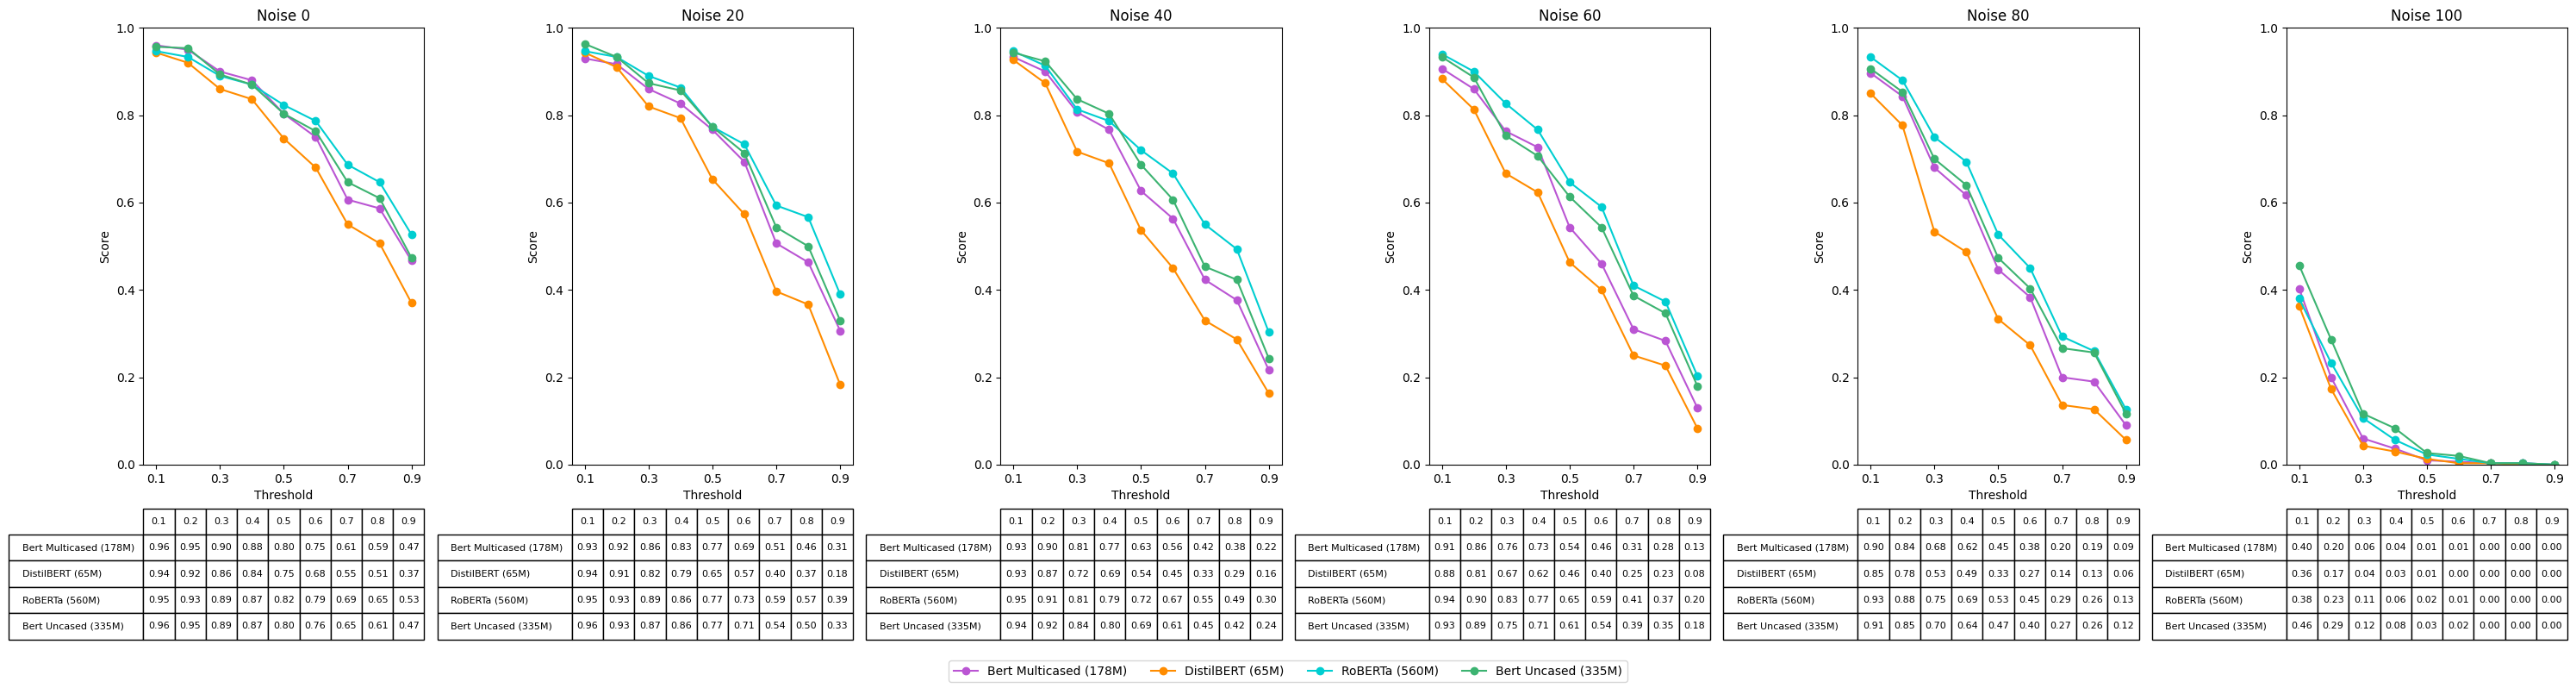

In [55]:
# Inicializar diccionarios para almacenar los resultados
accuracy_noise_0 = {}
accuracy_noise_20 = {}
accuracy_noise_40 = {}
accuracy_noise_60 = {}
accuracy_noise_80 = {}
accuracy_noise_100 = {}

# Calcular las accuracies para cada archivo
for name, df in average_dataframes.items():

    accuracy_noise_0[name] = calculate_accuracies_jaccard(df, 'Noise_0')
    accuracy_noise_20[name] = calculate_accuracies_jaccard(df, 'Noise_20')
    accuracy_noise_40[name] = calculate_accuracies_jaccard(df, 'Noise_40')
    accuracy_noise_60[name] = calculate_accuracies_jaccard(df, 'Noise_60')
    accuracy_noise_80[name] = calculate_accuracies_jaccard(df, 'Noise_80')
    accuracy_noise_100[name] = calculate_accuracies_jaccard(df, 'Noise_100')

# Crear los subplots
fig, axes = plt.subplots(1, 6, figsize=(30, 8), sharex=True)

# Subplots para cada categoría de ruido
plot_subplot(axes, 0, accuracy_noise_0, 'Noise 0')
plot_subplot(axes, 1, accuracy_noise_20, 'Noise 20')
plot_subplot(axes, 2, accuracy_noise_40, 'Noise 40')
plot_subplot(axes, 3, accuracy_noise_60, 'Noise 60')
plot_subplot(axes, 4, accuracy_noise_80, 'Noise 80')
plot_subplot(axes, 5, accuracy_noise_100, 'Noise 100')

plt.xticks(ticks=np.arange(0.1, 1.0, 0.2))
plt.tight_layout()

# Crear una sola leyenda para todos los subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(handles))

# Ajustar los márgenes para dar espacio a las tablas y la leyenda
plt.subplots_adjust(bottom=0.32)

# Guardar y mostrar el gráfico
plt.savefig('plots/em_threshold_jaccard.png', bbox_inches='tight')
plt.show()

## 1.2. E (Cosine)

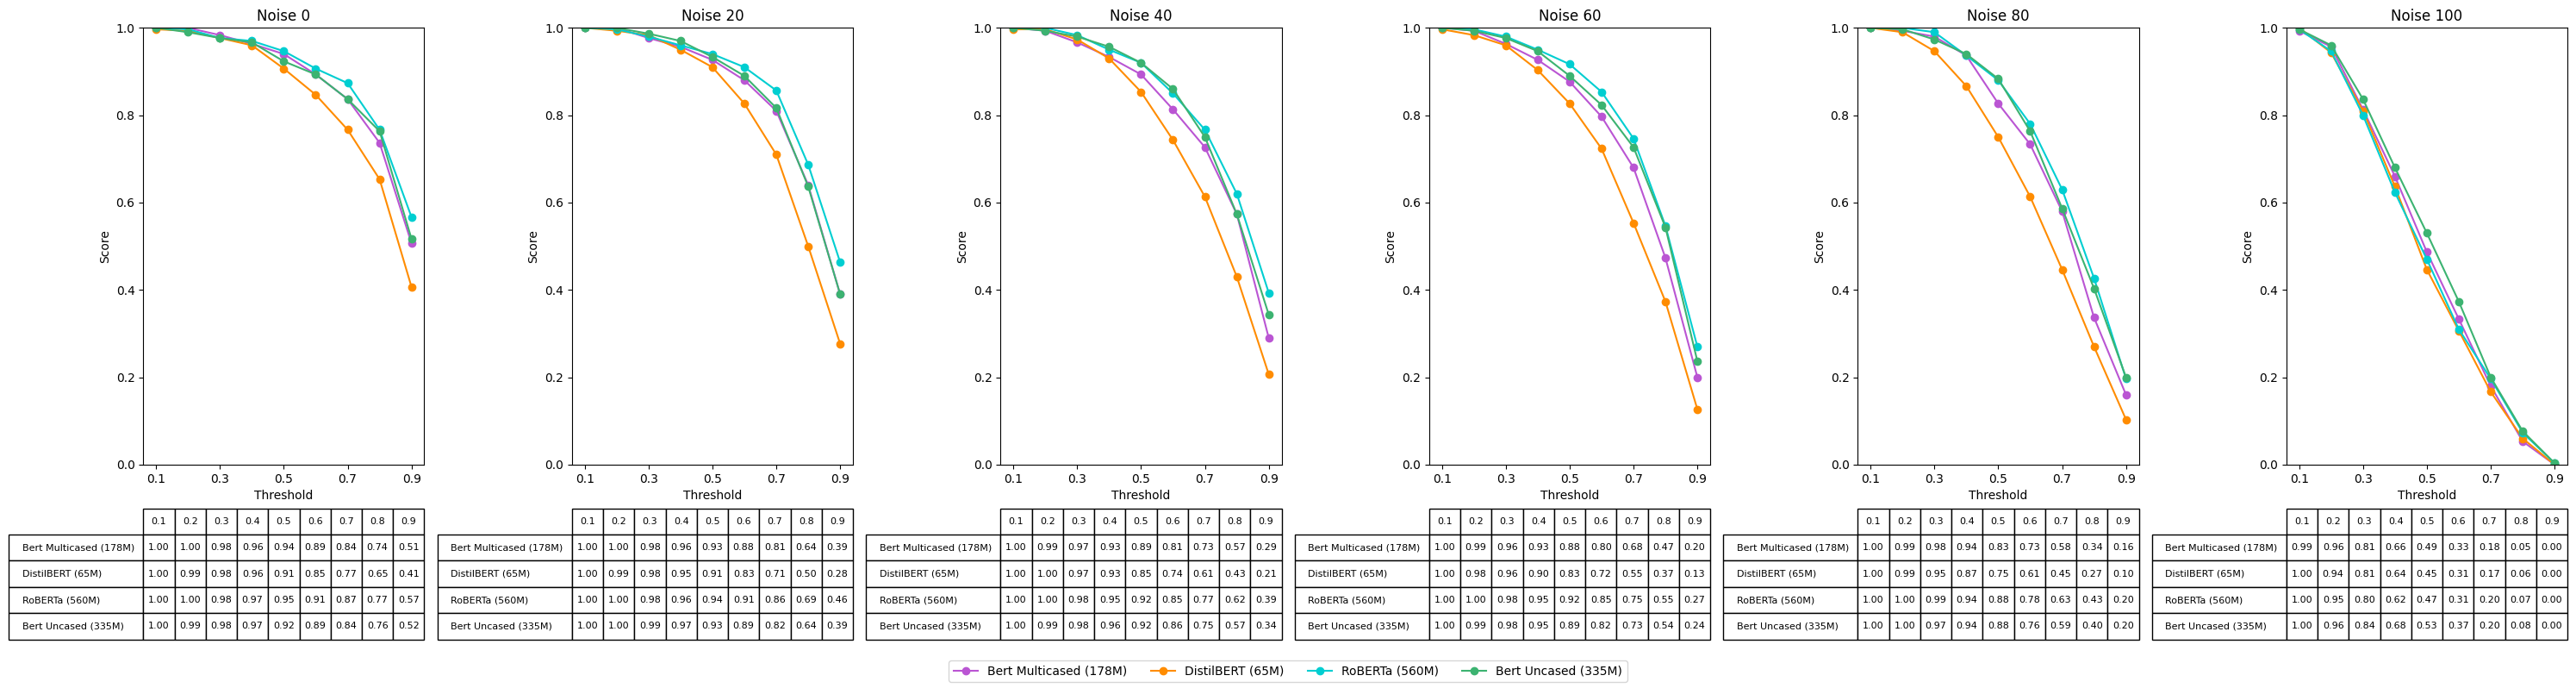

In [56]:
# Inicializar diccionarios para almacenar los resultados
accuracy_noise_0 = {}
accuracy_noise_20 = {}
accuracy_noise_40 = {}
accuracy_noise_60 = {}
accuracy_noise_80 = {}
accuracy_noise_100 = {}

# Calcular las accuracies para cada archivo
for name, df in average_dataframes.items():

    accuracy_noise_0[name] = calculate_accuracies_cosine(df, 'Noise_0')
    accuracy_noise_20[name] = calculate_accuracies_cosine(df, 'Noise_20')
    accuracy_noise_40[name] = calculate_accuracies_cosine(df, 'Noise_40')
    accuracy_noise_60[name] = calculate_accuracies_cosine(df, 'Noise_60')
    accuracy_noise_80[name] = calculate_accuracies_cosine(df, 'Noise_80')
    accuracy_noise_100[name] = calculate_accuracies_cosine(df, 'Noise_100')

# Crear los subplots
fig, axes = plt.subplots(1, 6, figsize=(30, 8), sharex=True)

# Subplots para cada categoría de ruido
plot_subplot(axes, 0, accuracy_noise_0, 'Noise 0')
plot_subplot(axes, 1, accuracy_noise_20, 'Noise 20')
plot_subplot(axes, 2, accuracy_noise_40, 'Noise 40')
plot_subplot(axes, 3, accuracy_noise_60, 'Noise 60')
plot_subplot(axes, 4, accuracy_noise_80, 'Noise 80')
plot_subplot(axes, 5, accuracy_noise_100, 'Noise 100')

plt.xticks(ticks=np.arange(0.1, 1.0, 0.2))
plt.tight_layout()

# Crear una sola leyenda para todos los subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(handles))

# Ajustar los márgenes para dar espacio a las tablas y la leyenda
plt.subplots_adjust(bottom=0.32)

# Guardar y mostrar el gráfico
plt.savefig('plots/em_threshold_cosine.png', bbox_inches='tight')
plt.show()

# 3. F1 Score Plots

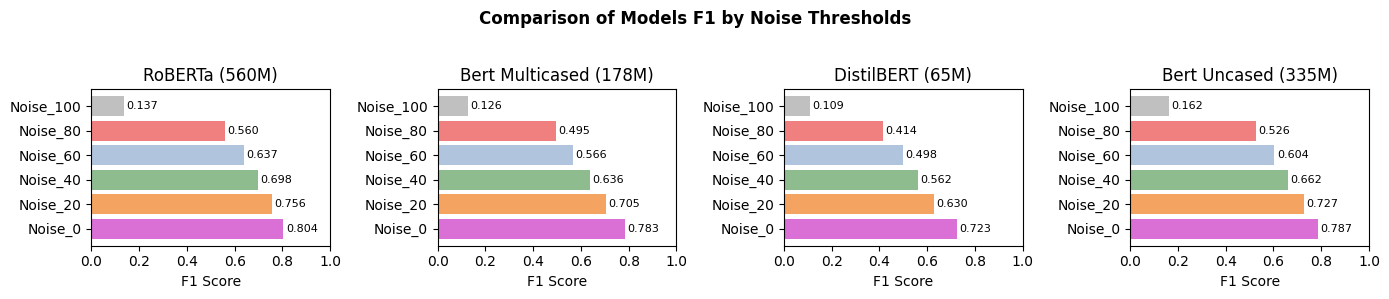

In [98]:
metric_name = 'F1'
file_path = 'metrics/ext/final_metrics.xlsx'
f1_data = extract_metrics_from_excel(file_path, metric_name)

# Crear un DataFrame a partir de los datos extraídos
f1_df = pd.DataFrame({
    model: {
        'Noise_0': data['Noise_0_Mean'],
        'Noise_20': data['Noise_20_Mean'],
        'Noise_40': data['Noise_40_Mean'],
        'Noise_60': data['Noise_60_Mean'],
        'Noise_80': data['Noise_80_Mean'],
        'Noise_100': data['Noise_100_Mean'],
    }
    for model, data in f1_data.items()
}).transpose()

# Transponer el DataFrame para que los niveles de ruido sean los índices
f1_df = f1_df.transpose()

# Configuración de colores
colors = ['orchid', 'sandybrown', 'darkseagreen', 'lightsteelblue', 'lightcoral', 'silver']

# Crear figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 3), sharex=True)

# Graficar cada modelo en un subgráfico separado
for ax, (model, data) in zip(axes, f1_df.items()):
    bars = ax.barh(f1_df.index, data, color=colors)
    ax.set_title(model, size=12)
    ax.set_xlabel('F1 Score', size=10)
    ax.set_xlim(0, 1)  # Ajustar el rango del eje X

    # Agregar las etiquetas de valores en las barras
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.01  # ajustar para que el texto no esté demasiado pegado a la barra
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', size=8)

# Añadir título general a la figura
fig.suptitle('Comparison of Models F1 by Noise Thresholds', fontsize=12, fontweight='bold')

# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar el gráfico
plt.show()
fig.savefig('plots/F1_comparison.png')

# 4. EM Plots

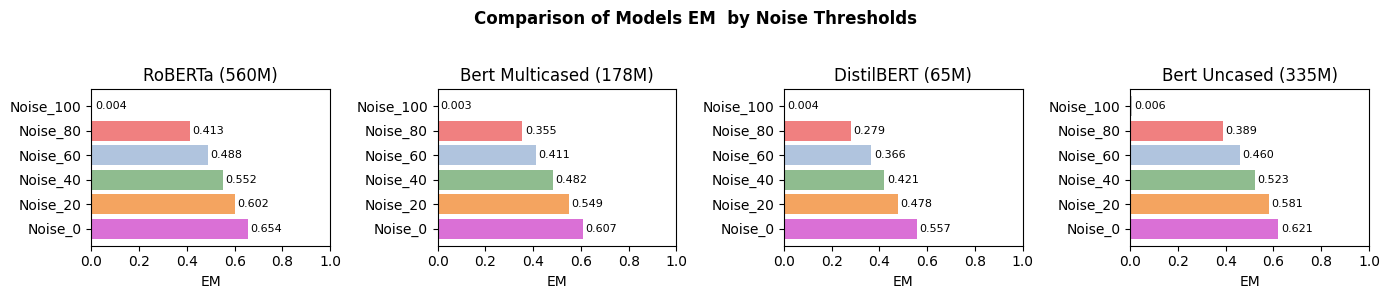

In [99]:
metric_name = 'EM - String'
file_path = 'metrics/ext/final_metrics.xlsx'
f1_data = extract_metrics_from_excel(file_path, metric_name)

# Crear un DataFrame a partir de los datos extraídos
f1_df = pd.DataFrame({
    model: {
        'Noise_0': data['Noise_0_Mean'],
        'Noise_20': data['Noise_20_Mean'],
        'Noise_40': data['Noise_40_Mean'],
        'Noise_60': data['Noise_60_Mean'],
        'Noise_80': data['Noise_80_Mean'],
        'Noise_100': data['Noise_100_Mean'],
    }
    for model, data in f1_data.items()
}).transpose()

# Transponer el DataFrame para que los niveles de ruido sean los índices
f1_df = f1_df.transpose()

# Configuración de colores
colors = ['orchid', 'sandybrown', 'darkseagreen', 'lightsteelblue', 'lightcoral', 'silver']

# Crear figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 3), sharex=True)

# Graficar cada modelo en un subgráfico separado
for ax, (model, data) in zip(axes, f1_df.items()):
    bars = ax.barh(f1_df.index, data, color=colors)
    ax.set_title(model, size=12)
    ax.set_xlabel('EM', size=10)
    ax.set_xlim(0, 1)  # Ajustar el rango del eje X

    # Agregar las etiquetas de valores en las barras
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.01  # ajustar para que el texto no esté demasiado pegado a la barra
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', size=8)

# Añadir título general a la figura
fig.suptitle('Comparison of Models EM  by Noise Thresholds', fontsize=12, fontweight='bold')

# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar el gráfico
plt.show()
fig.savefig('plots/EM_comparison.png')

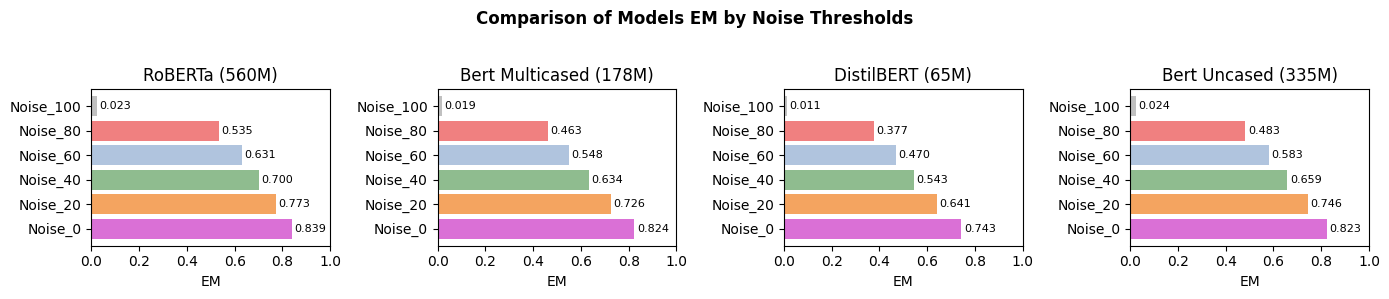

In [100]:
metric_name = 'EM - 2V'
file_path = 'metrics/ext/final_metrics.xlsx'
f1_data = extract_metrics_from_excel(file_path, metric_name)

# Crear un DataFrame a partir de los datos extraídos
f1_df = pd.DataFrame({
    model: {
        'Noise_0': data['Noise_0_Mean'],
        'Noise_20': data['Noise_20_Mean'],
        'Noise_40': data['Noise_40_Mean'],
        'Noise_60': data['Noise_60_Mean'],
        'Noise_80': data['Noise_80_Mean'],
        'Noise_100': data['Noise_100_Mean'],
    }
    for model, data in f1_data.items()
}).transpose()

# Transponer el DataFrame para que los niveles de ruido sean los índices
f1_df = f1_df.transpose()

# Configuración de colores
colors = ['orchid', 'sandybrown', 'darkseagreen', 'lightsteelblue', 'lightcoral', 'silver']

# Crear figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 3), sharex=True)

# Graficar cada modelo en un subgráfico separado
for ax, (model, data) in zip(axes, f1_df.items()):
    bars = ax.barh(f1_df.index, data, color=colors)
    ax.set_title(model, size=12)
    ax.set_xlabel('EM', size=10)
    ax.set_xlim(0, 1)  # Ajustar el rango del eje X

    # Agregar las etiquetas de valores en las barras
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.01  # ajustar para que el texto no esté demasiado pegado a la barra
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center', size=8)

# Añadir título general a la figura
fig.suptitle('Comparison of Models EM by Noise Thresholds', fontsize=12, fontweight='bold')

# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar el gráfico
plt.show()
fig.savefig('plots/EM_2V_comparison.png')